# Image search with Transformers Agents

🤗 [Transformers Agent](https://huggingface.co/docs/transformers/transformers_agents) is a framework for [augmenting large language models](https://arxiv.org/abs/2302.07842) with [external tools](https://huggingface.co/docs/transformers/en/custom_tools) via prompting. This notebook demonstrates how a 🤗 agent can be extended with custom image search tools that support image search by both query text and query image. Images are searched in the public [LAION-5B image dataset](https://laion.ai/blog/laion-5b/). The following example uses a chat agent, driven by OpenAI's `gpt-3.5-turbo` model, to

1. generate an image of a running dog
2. search for similar images in the LAION-5B dataset
3. generate a caption for one of the images in the search result
4. search for more images with the caption as query text



## Setup

In [ ]:
#@title Setup
transformers_version = "v4.29.0" #@param ["main", "v4.29.0"] {allow-input: true}

!pip install git+https://github.com/huggingface/transformers@$transformers_version -q diffusers accelerate torch openai clip-retrieval

## Helper functions

Functions `image_search` and `visual_search` use [clip-retrieval](https://github.com/rom1504/clip-retrieval) library for searching images in the LAION-5B dataset.

In [2]:
from tempfile import NamedTemporaryFile
from clip_retrieval.clip_client import ClipClient, Modality


def image_search(query_text, k=5):
    """Search for images in LAION-5B using a text query."""
    search_result = client(k * 2).query(text=query_text)
    return download_images(search_result, k=k)


def visual_search(query_image, k=5):
    """Search for images in LAION-5B using a visual query."""
    with NamedTemporaryFile(dir=".") as f:
        query_image.save(f, format="PNG")
        search_result = client(k * 2).query(image=f.name)
    return download_images(search_result, k=k)


def client(k: int):
    return ClipClient(
        url="https://knn.laion.ai/knn-service",
        indice_name="laion5B-L-14",
        modality=Modality.IMAGE,
        aesthetic_score=0,
        aesthetic_weight=0.0,
        deduplicate=False,
        num_images=k,
    )

The `download_images` helper function downloads images from URLs contained in a search result.

In [3]:
import requests


def download_images(search_results, k):
    downloads = []

    for search_result in search_results:
        if len(downloads) >= k:
            break
        try:
            img = download_image(search_result["url"])
            if img:
                downloads.append(img)
        except:
            continue

    return downloads


def download_image(image_url):
        image_stream = requests.get(image_url, stream=True)
        if image_stream.status_code == 200:
            image = Image.open(image_stream.raw)
            image.load()
            return image

The `display_image` helper resizes images before displaying them.

In [4]:
def display_image(image, size=200):
    image_copy = image.copy()
    image_copy.thumbnail(size=(size, size))
    display(image_copy)

## Image search tools

Classes `ImageSearchTool` and `VisualSearchTool` are [custom tools](https://huggingface.co/docs/transformers/en/custom_tools) that use the helper function defined above. Their `name` and `description` follow the style of [built-in tools](https://huggingface.co/docs/transformers/en/transformers_agents#a-curated-set-of-tools). 

**Tip:** For following the style of built-in tools, try using an LLM to generate tool descriptions by prompting with the names and descriptions of other tools. For example, the following tool descriptions were generated with [Github Copilot](https://github.com/features/copilot) (with only minor manual post-processing).

In [5]:
from PIL import Image
from transformers import Tool

class ImageSearchTool(Tool):
    name = "image_search"
    description = (
        "This is a tool that searches for images according to a text description. It takes an input named "
        "`query` which contains the query text, as well as an optional input `k` which will be the number "
        "of images to return. The default is of 5 images. The tool outputs a list of image objects."
    )

    inputs = ["text"]
    outputs = ["image"]

    def __call__(self, query: str, k: int = 5):
        """Search for images in LAION-5B using a text query."""
        return image_search(query, k=k)


class VisualSearchTool(Tool):
    name = "visual_search"
    description = (
        "This is a tool that searches for images according to a visual query. It takes an input named "
        "`image` which contains the image to use as the query, as well as an optional input `k` which "
        "will be the number of images to return. The default is of 5 images. The tool outputs a list "
        "of image objects."
    )

    inputs = ["image"]
    outputs = ["image"]

    def __call__(self, image: Image, k: int = 5):
        """Search for images in LAION-5B using a visual query."""
        return visual_search(image, k=k)

## Create chat agent

The chat agent is an `OpenAiAgent` backed by a `gpt-3.5-turbo` model. You need an OpenAI API key for using it.

In [6]:
import getpass

api_key = getpass.getpass("OpenAI API key:")

OpenAI API key:··········


The custom search tools are passed as `additional_tools` argument to the agent constructor.

In [7]:
from transformers import OpenAiAgent

tools = [ImageSearchTool(), VisualSearchTool()]
agent = OpenAiAgent(model="gpt-3.5-turbo", additional_tools=tools, api_key=api_key)

## Use chat agent

First, generate an image of a running dog. This uses the built-in `image_generator` tool.

==Explanation from the agent==
I will use the tool `image_generator` to generate an image of a running dog.


==Code generated by the agent==
prompt = "A picture of a dog running"
image = image_generator(prompt)


==Result==


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

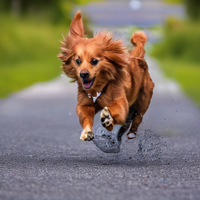

In [8]:
generated_image = agent.chat("Generate an image of a running dog.")
display_image(generated_image)

Then search LAION-5B for images that are similar to the generated image. From the description of the search tools, the language model knows that the `visual_search` tool is appropriate here. The user instruction doesn't specify the number of returned images, so 5 images are returned by default.

==Explanation from the agent==
I will use the tool `visual_search` to find visually similar images to the generated image.


==Code generated by the agent==
similar_images = visual_search(image=image)
print(f"The visually similar images are: {similar_images}")


==Result==
The visually similar images are: [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=270x270 at 0x7F5F7716D270>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=639x385 at 0x7F5F7716CEE0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1688x1055 at 0x7F5F77AD7C40>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=553x311 at 0x7F5F77AD79D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=825x621 at 0x7F5F77AD7820>]


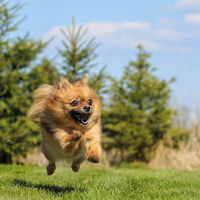

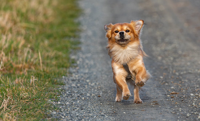

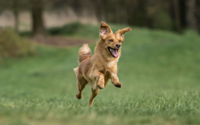

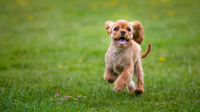

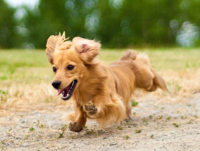

In [9]:
similar_images = agent.chat("Search images that are visually similar to the generated image.")
for image in similar_images:
    display_image(image)

Use the built-in `image_captioner` tool to create a caption of the third image in the result set. The language model correctly references to this image with `similar_images[2]` in the generated code.

In [10]:
caption = agent.chat("Create a caption of the third image of the search result.")

==Explanation from the agent==
I will use the tool `image_captioner` to generate a caption for the third image in the search result.


==Code generated by the agent==
third_image = similar_images[2]
caption = image_captioner(image=third_image)
print(f"The caption for the third image is: {caption}")


==Result==


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


The caption for the third image is: a dog running in a field of grass


Finally, search three images using the caption as query text. This instruction selects the `image_search` tool and correctly passes `k=3` as additional argument.

==Explanation from the agent==
I will use the tool `image_search` to find 3 images that match the caption text.


==Code generated by the agent==
matched_images = image_search(query=caption, k=3)
print(f"The matched images are: {matched_images}")


==Result==
The matched images are: [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x357 at 0x7F5FBE9D6E60>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x320 at 0x7F5F77AD7AF0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x320 at 0x7F5F7716C2B0>]


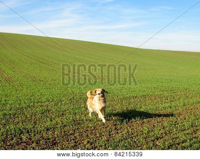

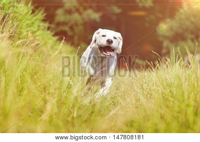

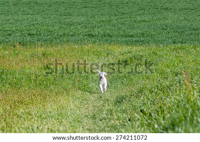

In [11]:
matching_images = agent.chat("Search 3 images that match the caption text.")
for image in matching_images:
    display_image(image)

## Conclusion


🤗 Transformers Agents is a framework for application development with large language models. It connects language models with external tools and has first-class support for multimodal tasks. This is a major advantage over frameworks like [langchain](https://python.langchain.com/en/latest/index.html), for example. Langchain needs to handle non-text data in a serialized form (e.g. by writing them to disk and referencing them by their path). 

Visual ChatGPT is an example of a langchain based multimodal application. It can also be extended with custom tools like image search engines, as described in [this blog post](https://krasserm.github.io/2023/04/03/visual-chatgpt-search/), for example, but it makes handling of multimodal data more complex. On the other hand, langchain is currently better at processing more complex user instructions e.g. by implementing approaches like [ReAct](https://arxiv.org/abs/2210.03629) but I'm sure we will see something similar in 🤗 Transformers Agents soon.